# Aggregated data analysis

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)


# Local Modules
import sys
import os.path
sys.path.insert(0, os.path.abspath('/scratch/horta/coronawiki/'))
from helpers.load import load_interventions, load_aggregated, load_topics, load_pca
from helpers.vars import helper_langs, interventions_helper, int_c, int_ls
from helpers.plot import set_size, plot_dates, plot_intervention, plot_cumm_diff

In [2]:
# Latex Configuration
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib as mpl


PARAM = {
    "axes.titlesize" : 14,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'text.usetex': True
}

mpl.rcParams.update(PARAM)

In [6]:
interventions = load_interventions("data/interventions.csv")
topics_df, topics = load_topics('data/topics_linked.csv.xz')
agg = load_aggregated("data/aggregated_timeseries.json.gz")
codes_order = ["sr", "it", "fr", "en", "nl", "ko", "de", "fi", "ja", "no", "sv", "da"]
time_int = 35
dfs_pca_shift = load_pca(codes_order, pca_folder="pca/")

## Video/Games

In [5]:
number_vg = agg['fr']['topics']['Culture.Media.Video games']['len']
sum_vg = agg['fr']['topics']['Culture.Media.Video games']['sum']
percent_vg = agg['fr']['topics']['Culture.Media.Video games']['percent']

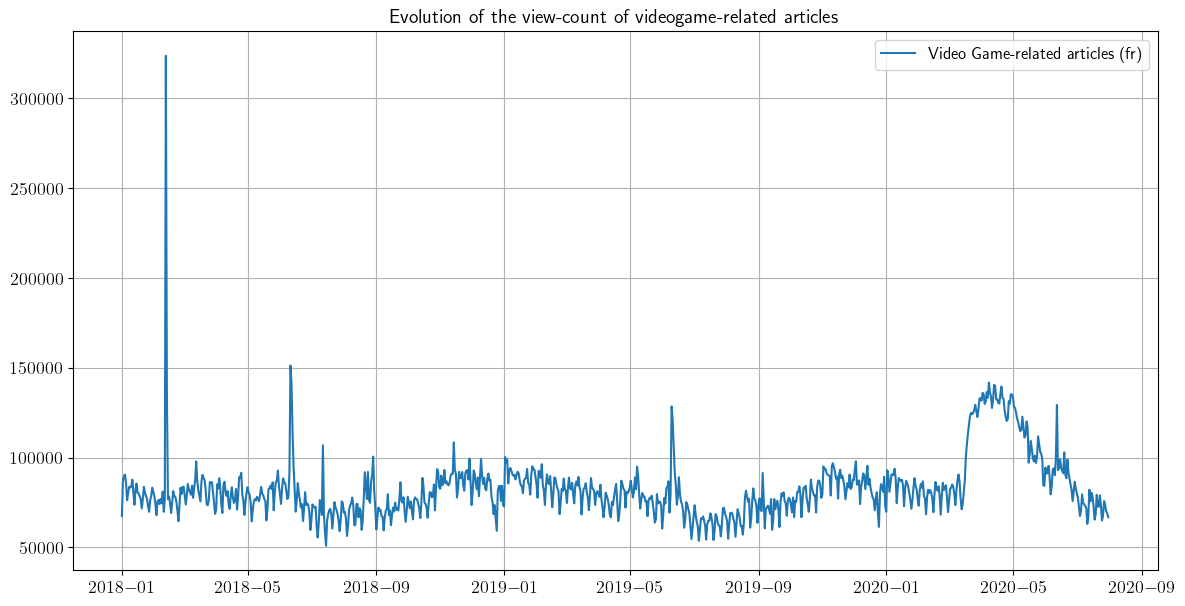

In [7]:
plt.figure(figsize=(14,7))
plt.plot(agg['fr']["sum"].index,sum_vg, label="Video Game-related articles (fr)")
plt.grid()
plt.legend()
plt.title("Evolution of the view-count of videogame-related articles")
plt.show()

136.1890425499862
0.01945678600316593
60.80184796495083
-7.894862547890825
49.54210139991962
-1.4401278590242963
46.98163023521538
-2.312153732317933
51.39047588374955
-1.7703282711053323
38.87420521753462
-1.3778555511322512
39.22795510864916
-3.308358049087432
10.368721390068144
-9.556351779827425
26.442053921578676
-10.506345453251257
10.649013938569725
-5.357599168028525
5.096779753608904
-9.075180835992121
0.1833501902097288
-13.877606413605273


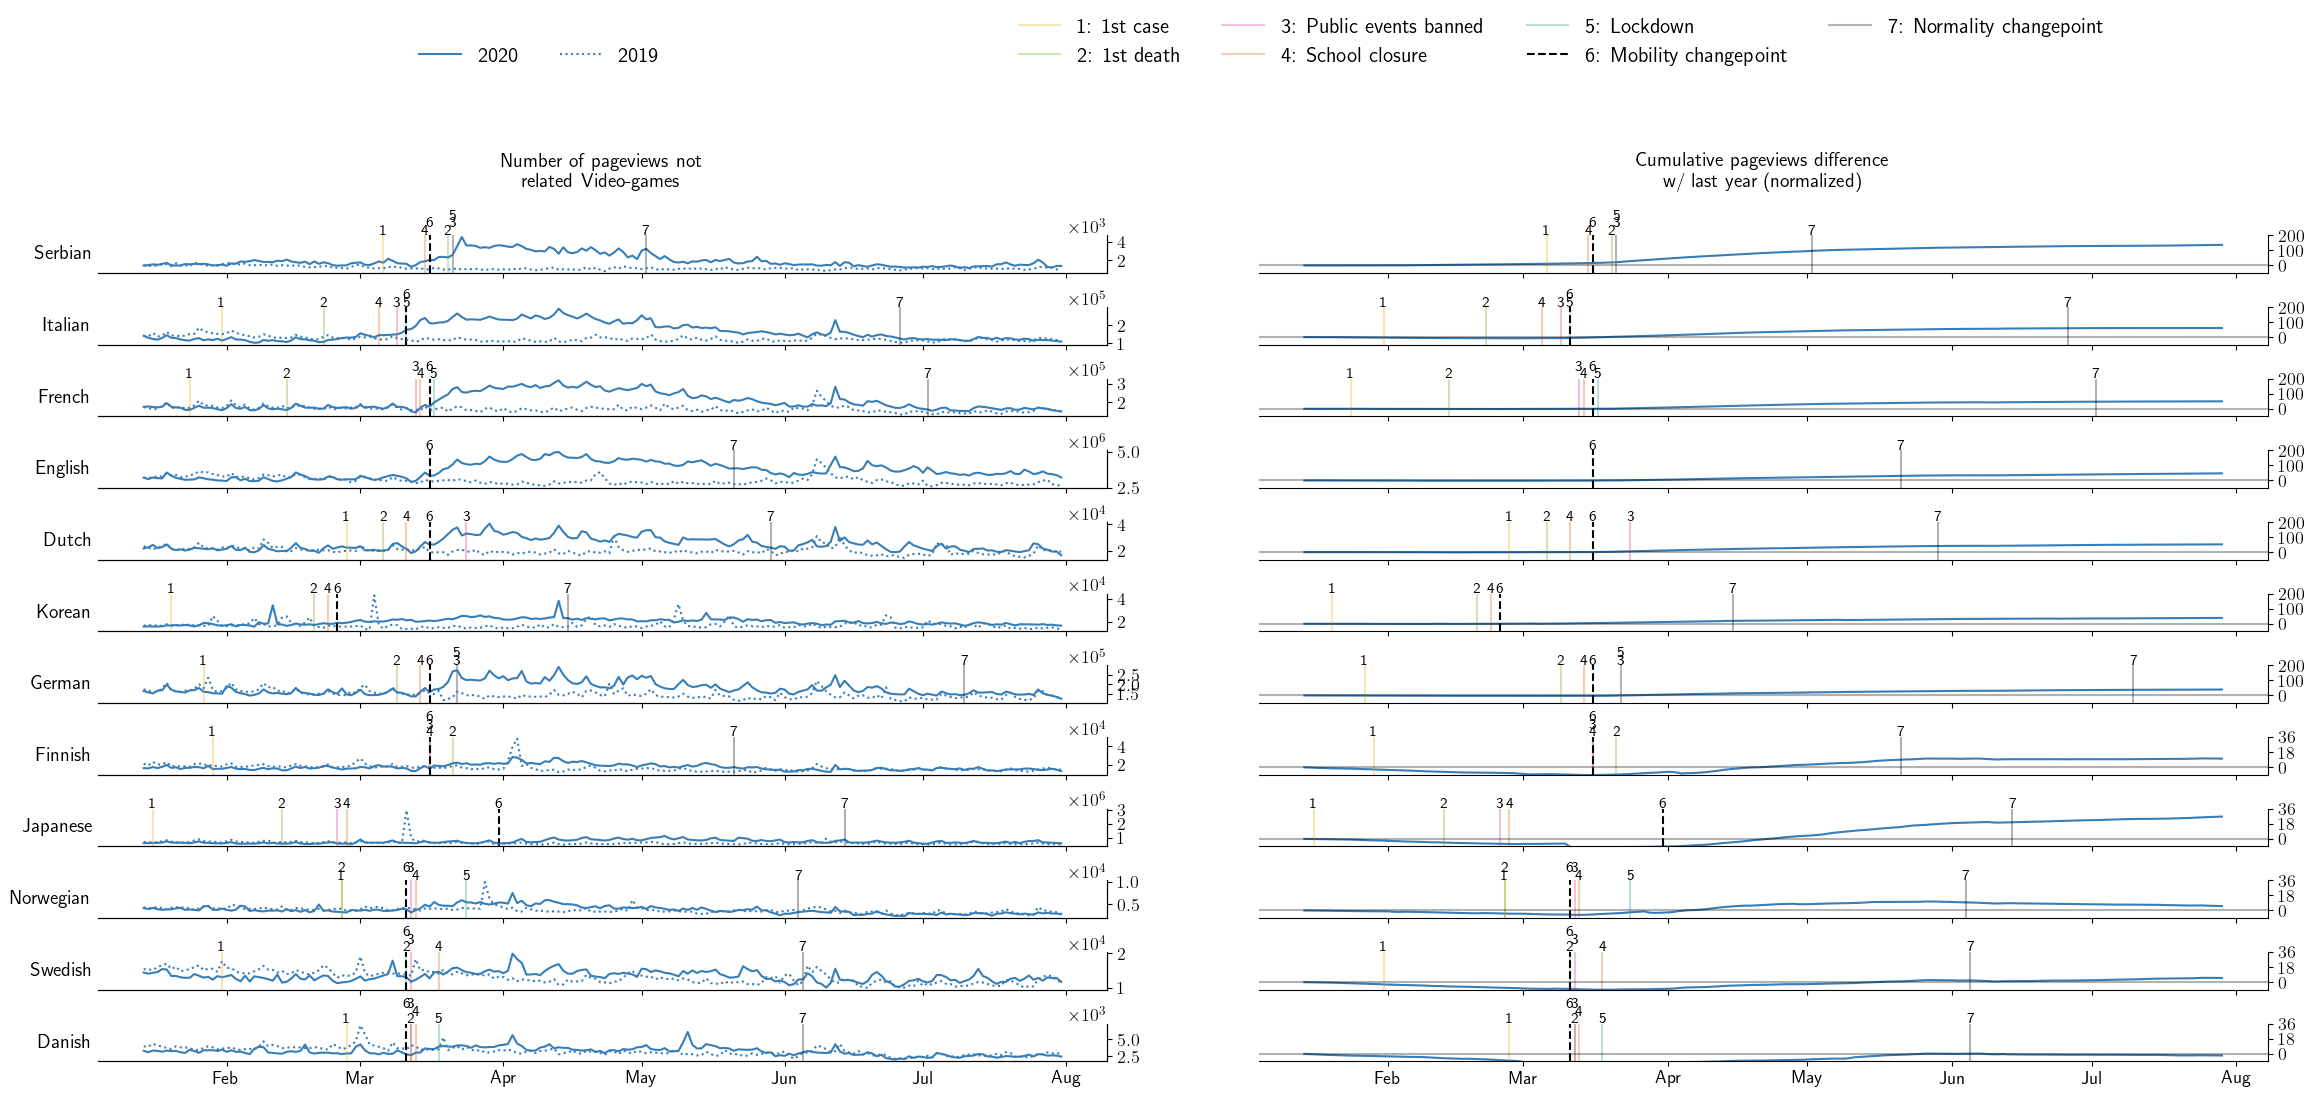

In [8]:
fig, axs = plt.subplots(12, 2,
                        figsize=(28, 14),
                        sharex=False,
                        gridspec_kw={"hspace": 0.9, "wspace": 0.15, "top": 0.7})

for idx, ax_ in enumerate(axs[:, :]):


    # VIDEO-GAME-RELATED PAGEVIEWS

    ax = ax_[0]
    code = codes_order[idx]
    ax.set_ylabel(helper_langs[code], rotation=0, ha="right", va="center", fontsize=14)
    ax_twin = ax.twiny()

    start, end = plot_dates(ax, 20200114, 20200731,
                            agg[code]["sum"].index, agg[code]['topics']['Culture.Media.Video games']["sum"].values + agg[code + ".m"]['topics']['Culture.Media.Video games']["sum"].values,
                            color="#377eb8", sci=False)

    plot_dates(ax_twin, 20190114, 20190731, agg[code]["sum"].index,
               agg[code]['topics']['Culture.Media.Video games']["sum"].values + agg[code + ".m"]['topics']['Culture.Media.Video games']["sum"].values,
               adjust=(start, end), sci=False, xticklabels=False, ls=":", color="#377eb8")


    plot_intervention(ax, interventions, code, "all", interventions_helper, int_ls, int_c)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

    for ax_t in [ax, ax_twin]:
        ax_t.spines['left'].set_visible(False)
        ax_t.spines['top'].set_visible(False)
        ax_t.yaxis.set_ticks_position('right')

    # CUMULATIVE PAGE VIEWS DIFFERENCE

    ax = ax_[1]

    plot_cumm_diff(ax, (20190101, 20191231), [20190115, 20200114], [20190731, 20200729],
                   agg[code]["sum"].index,
                   agg[code]['topics']['Culture.Media.Video games']["sum"].values + agg[code + ".m"]['topics']['Culture.Media.Video games']["sum"].values
                   )

    plot_intervention(ax, interventions, code, "all", interventions_helper, int_ls, int_c)

    ax.set_ylim([-7.5, 15])
    ax.axhline(0, color="black", alpha=0.3)

    for ax_t in [ax]:
        ax_t.spines['left'].set_visible(False)
        ax_t.spines['top'].set_visible(False)
        ax_t.yaxis.set_ticks_position('right')

    if idx in[0,1,2,3,4,5,6]:
        ax.set_ylim(-50,200)
        ax.set_yticks([0, 100, 200])

    else:
        ax.set_ylim(-9,36)
        ax.set_yticks([0, 18, 36])

    for ax in ax_:
        if idx != 11:
            ax.set_xticklabels([])


axs[0,0].set_title("Number of pageviews not\n related Video-games ", pad=35)
axs[0,1].set_title("Cumulative pageviews difference \n w/ last year (normalized)", pad=35)


lines = [
    Line2D([0], [0], color="#377eb8", lw=1.5, ls="-"),
    Line2D([0], [0], color="#377eb8", lw=1.5, ls=":"),
    Line2D([0], [0], color="black", lw=1.5, ls=":")
]

axs[0,0].legend(
    handles=lines,
    labels=["2020", "2019"],
    loc='lower left', bbox_to_anchor=(0.3, 5),
    ncol=3, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=15
)


lines_interv = [Line2D([0], [0], color=int_c[x], ls=int_ls[x], alpha=0.3 if x != "Mobility" else 1.)
                for x, _ in interventions_helper.items()]

axs[0,1].legend(
    handles= lines_interv,
    labels=["{}: {}".format(v,
                            k.replace("Mobility", "Mobility changepoint")\
                            .replace("Normalcy", "Normality changepoint"))
            for k, v in interventions_helper.items()],
    loc='lower center', bbox_to_anchor=(0.3, 5),
    ncol=4, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=15
)

# Wikipedia API - Genre specific analysis

This part will
+ Query video-game articles and associated genre from Wikipedia
+ Select genres with more than a chosen amount of instances
+ Extract monthly count-views for each genre, via the Wikipedia API
+ Save the obtained data in the file `video_game_genre2020`
+ Plot values

In [9]:
#useful imports
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
from urllib.request import urlopen
import json
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

Let's extract all video-games as well as their genre from Wikipedia

In [10]:
sparql.setQuery("""
    PREFIX bd: <http://www.bigdata.com/rdf#>
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX wikibase: <http://wikiba.se/ontology#>

select  ?objet ?objectLabel ?genreLabel ?url
where {
    ?object wdt:P31 wd:Q7889.
    ?object wdt:P136 ?genre.

    SERVICE wikibase:label {
      bd:serviceParam wikibase:language "en" .
    }
}
""")
sparql.setReturnFormat(JSON)
games_result = sparql.query().convert()

In [11]:
game_genre_df = pd.json_normalize(games_result['results']['bindings'])
game_genre_df

,objectLabel.xml:lang,objectLabel.type,objectLabel.value,genreLabel.xml:lang,genreLabel.type,genreLabel.value
0,en,literal,Lego Star Wars: The Complete Saga,en,literal,action-adventure game
1,en,literal,Lego Star Wars: The Video Game,en,literal,action-adventure game
2,en,literal,Star Wars Episode I: Racer,en,literal,racing video game
3,en,literal,Star Wars: Bounty Hunter,en,literal,action game
4,en,literal,Star Wars: Racer Arcade,en,literal,racing video game
...,...,...,...,...,...,...
48488,en,literal,The Sacred Pools,en,literal,graphic adventure game
48489,en,literal,Moirai,en,literal,indie game
48490,en,literal,Moirai,en,literal,horror video game
48491,en,literal,Don King Boxing,en,literal,boxing video game


If we count the number of unique genres, we can see there is a lot

In [12]:
unique_game_genre_df = game_genre_df['genreLabel.value'].unique()
unique_game_genre_df

array(['action-adventure game', 'racing video game', 'action game',
       'platform game', 'strategy video game', 'puzzle video game',
       "shoot 'em up", 'making-of', 'shooter game', 'real-time strategy',
       'fighting game', 'adventure game',
       'massively multiplayer online role-playing game',
       'role-playing video game', 'science fiction video game',
       'first-person shooter', 'third-person shooter',
       'space combat simulation game', 'arcade-style video game',
       'sports video game', 'bowling video game',
       'military education and training', '3D computer graphics software',
       'game creation system', 'vehicular combat game',
       'boxing video game', 'maze video game', 'stealth game',
       'side-scrolling video game', 'scrolling shooter',
       'simulation video game', 'Metroidvania', 'interactive fiction',
       'space flight simulation game', 'space trading and combat game',
       'video game with LGBT character', 'fishing video game',

We will consider here that categories with less than 1000 games are not relevant

In [13]:
test = game_genre_df.groupby(['genreLabel.value'])['objectLabel.value'].count()
irr = test[test.values<1000].index
test

genreLabel.value
2D computer graphics                                                             9
3D computer graphics                                                             7
3D computer graphics software                                                    1
3D video game                                                                    3
4X                                                                              58
American football video game                                                   226
Arcade Game Series                                                               1
Australian football video game                                                   9
B movie                                                                          4
BASIC                                                                            1
BMX video game                                                                   2
Breakout clone                                                        

Once the genres are chosen, we format the article names to enable the research later on

In [14]:
game_genre_df = game_genre_df.drop(game_genre_df[game_genre_df['genreLabel.value'].isin(irr)].index)
game_genre_df = game_genre_df.replace(' – ', '', regex=True)
game_genre_df = game_genre_df.replace('°', '', regex=True)
game_genre_df = game_genre_df.replace(' ', '_', regex=True)
game_genre_df = game_genre_df.replace('/', '_', regex=True)

In [15]:
unique_game_genre_df = game_genre_df['genreLabel.value'].unique()
unique_game_genre_df

array(['action-adventure_game', 'racing_video_game', 'action_game',
       'platform_game', 'puzzle_video_game', "shoot_'em_up",
       'adventure_game', 'role-playing_video_game',
       'science_fiction_video_game', 'first-person_shooter',
       'sports_video_game', 'visual_novel', 'indie_game'], dtype=object)

We can now extract the monthly count-views

In [18]:
def get_monthly_count(code, name, start_date,end_date):
    '''
    Will return a dataframe of the monthly count-views of an article for the period given and a chosen language
    '''

    url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{}.wikipedia/all-access/all-agents/{}/monthly/{}/{}'.format(code,name,start_date,end_date)
    response = urlopen(url)
    data_json = json.loads(response.read())
    df =  pd.json_normalize(data_json['items'])
    return df

In [19]:
df_action = get_monthly_count('en','Hitman:_Blood_Money','2020010100','2020123100')
dates = df_action.timestamp.tolist()
date = []
for d in dates:
    date.append(datetime.strptime(d, '%Y%m%d%H').strftime('%d/%m/%Y'))
date

['01/01/2020',
 '01/02/2020',
 '01/03/2020',
 '01/04/2020',
 '01/05/2020',
 '01/06/2020',
 '01/07/2020',
 '01/08/2020',
 '01/09/2020',
 '01/10/2020',
 '01/11/2020',
 '01/12/2020']

Now let's compute views for all genres, WARNING this cell takes a long time to compute

In [ ]:
monthly_views = np.zeros([12,1])

for g in range(len(unique_game_genre_df)):
    names = game_genre_df[game_genre_df['genreLabel.value']==unique_game_genre_df[g]]['objectLabel.value']
    monthly_views_genre = np.zeros([12,1])
    for n in names:
        try:
            df = get_monthly_count('en',n,'2020010100','2020123100')
            df=df.replace(np.nan, 0)
            views = (df.views).array
            views = np.reshape(views,[12,1])
            monthly_views_genre+=views
        except:
            pass
    monthly_views= np.append(monthly_views,monthly_views_genre,axis=1)

In [ ]:
final = monthly_views[:,1:]
df = pd.DataFrame(final, columns = unique_game_genre_df)
df.to_csv('video_game_genre2020.csv')

Finally, let’s plot what we found

In [16]:
games= pd.read_csv('data/video_game_genre2020.csv')
count = game_genre_df.groupby(['genreLabel.value'])['objectLabel.value'].count()

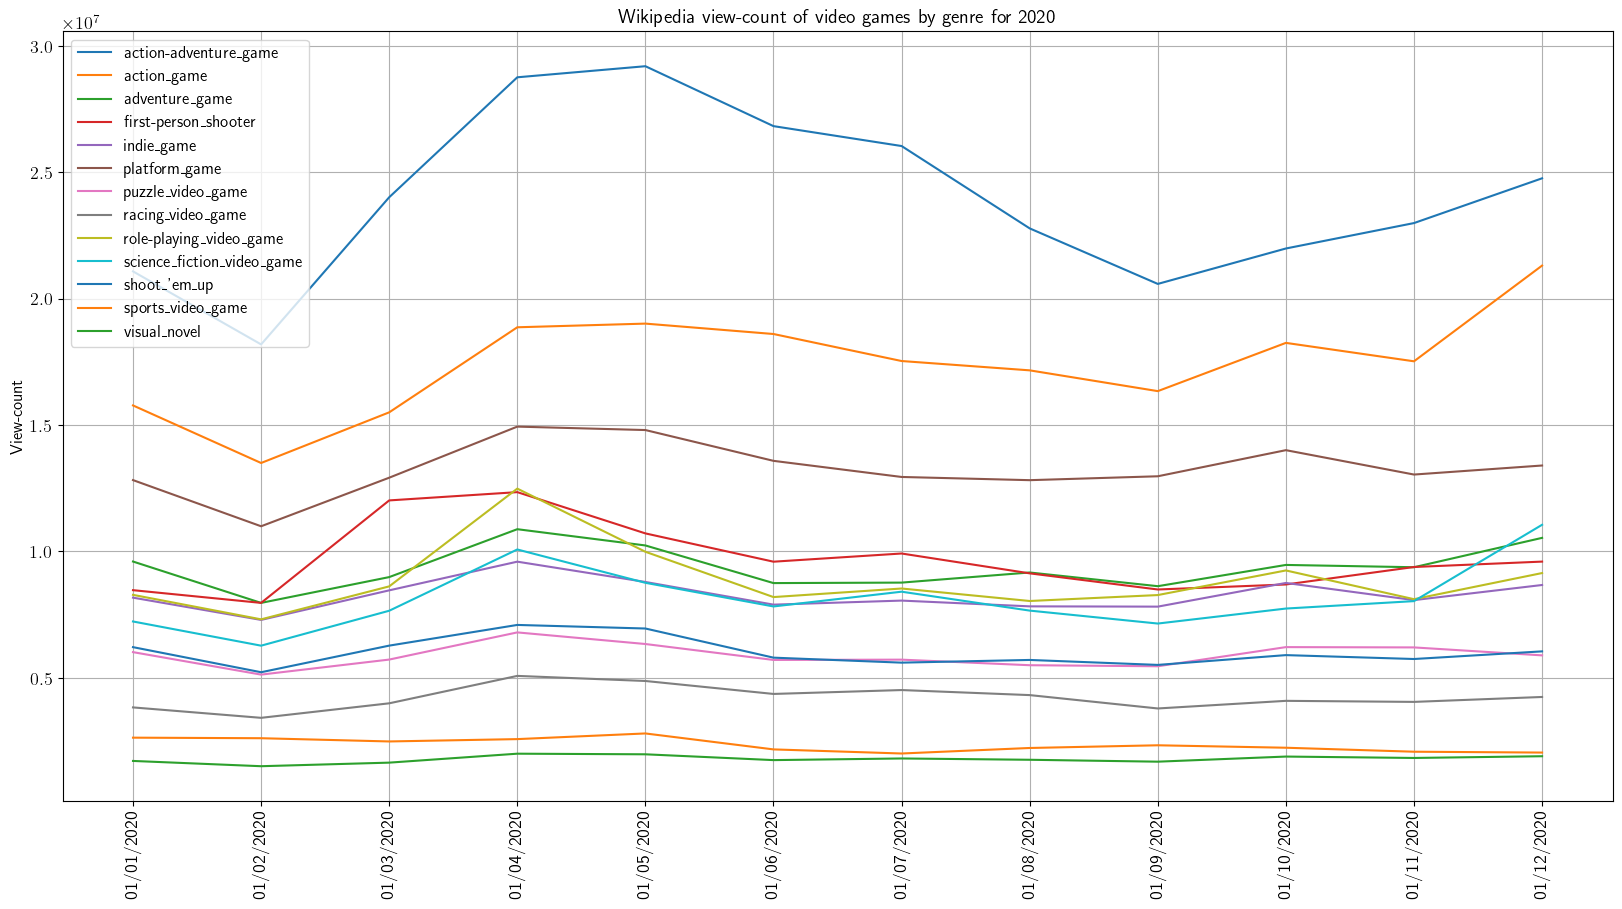

In [20]:
plt.figure(figsize=(20,10))
for g in count.index:
    plt.plot(dates, games['{}'.format(g)], label='{}'.format(g))

plt.tick_params(axis='x', labelrotation=90)
plt.legend()
plt.grid()
plt.title("Wikipedia view-count of video games by genre for 2020")
plt.ylabel("View-count")
plt.xticks(dates, date)
plt.show()

These were absolute view-counts, let’s see relative view-counts taking into consideration the amount of articles per genre.

In [21]:
for g in count.index:
    games['{}'.format(g)] = games['{}'.format(g)].apply(lambda x: x/count['{}'.format(g)])

games_relative = games

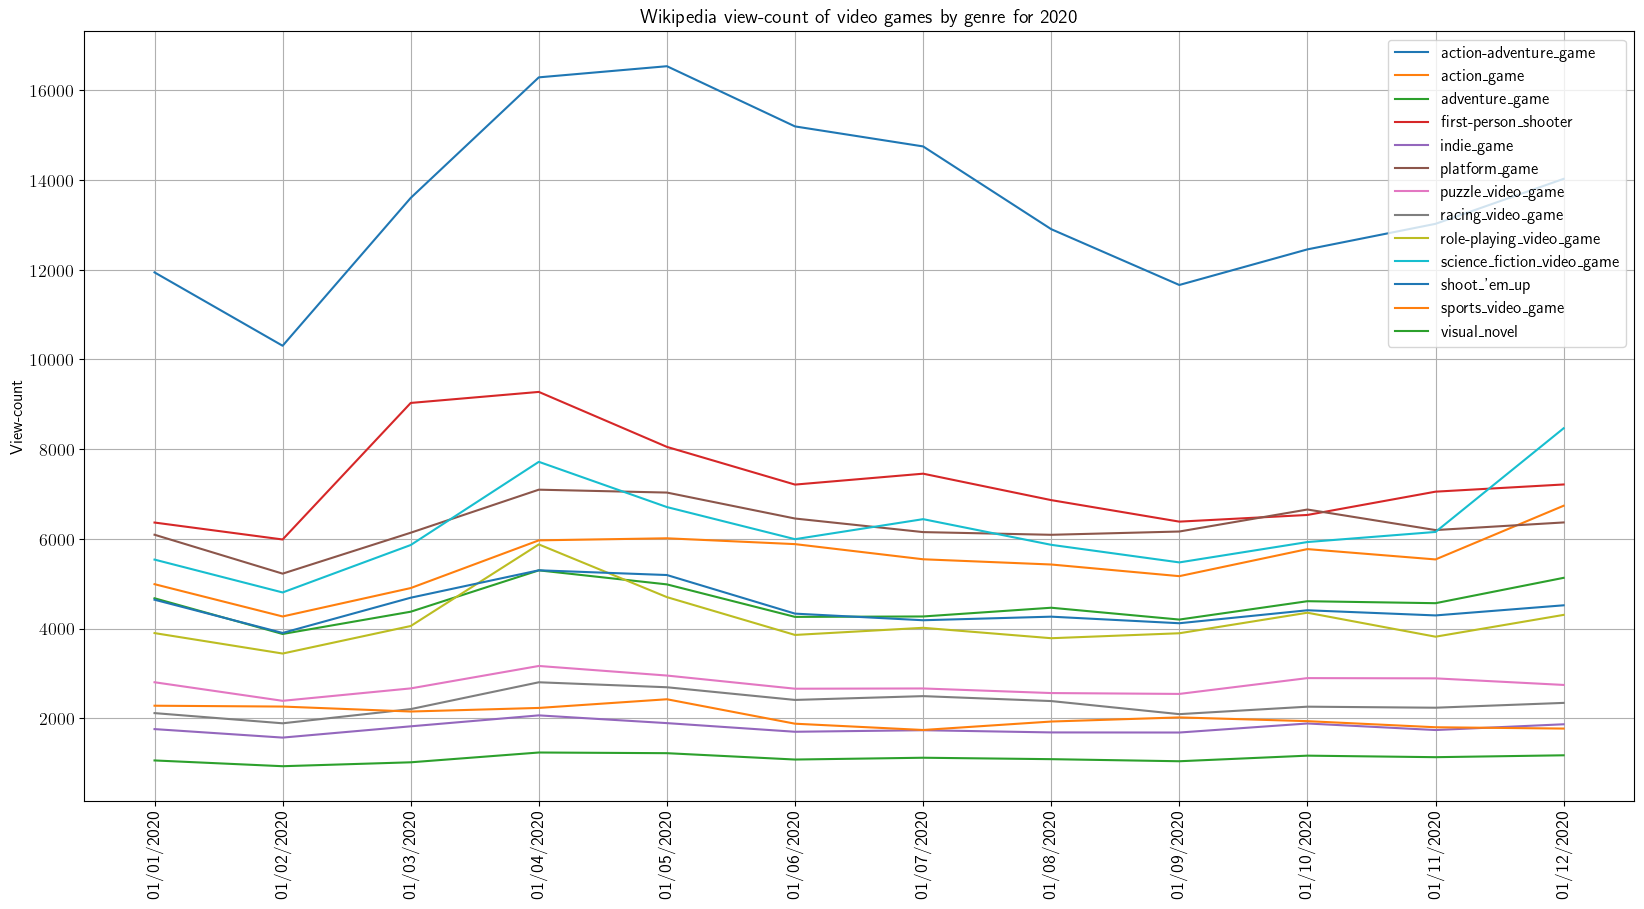

In [22]:
plt.figure(figsize=(20,10))

for g in count.index:
    plt.plot(dates, games_relative['{}'.format(g)], label='{}'.format(g))

plt.tick_params(axis='x', labelrotation=90)
plt.legend()
plt.grid()
plt.title("Wikipedia view-count of video games by genre for 2020")
plt.ylabel("View-count")
plt.xticks(dates, date)
plt.show()

In [23]:
games_relative=games_relative.drop(['Unnamed: 0'], axis=1)
games_relative['Total']=games_relative.sum(axis=1)
games_relative

,action-adventure_game,racing_video_game,action_game,platform_game,puzzle_video_game,shoot_'em_up,adventure_game,role-playing_video_game,science_fiction_video_game,first-person_shooter,sports_video_game,visual_novel,indie_game,Total
0,11942.273088,2114.606729,4989.505376,6092.052732,2802.646182,4643.014937,4675.296495,3898.906353,5537.770291,6363.956424,2279.416595,1059.101172,1757.989247,58156.535620
1,10306.212465,1887.334804,4269.512334,5224.532542,2388.648510,3902.061987,3878.816456,3442.998588,4805.055130,5986.232156,2260.509075,930.433683,1568.637419,50850.985149
2,13603.138810,2203.975731,4903.008539,6137.051781,2665.661546,4688.000747,4375.739046,4056.643765,5862.880551,9030.942149,2149.911841,1017.575571,1820.073333,62514.603409
3,16291.233428,2802.013238,5966.939279,7096.818052,3165.820298,5299.135922,5297.793574,5876.158588,7717.926493,9276.922615,2229.958513,1235.961752,2064.040645,74320.722397
4,16539.631161,2691.093767,6012.855787,7032.460808,2952.111266,5193.601942,4984.844206,4700.838588,6708.978560,8050.832457,2423.458946,1221.048735,1891.367527,70403.123752
5,15197.032861,2408.405957,5882.788741,6453.737767,2658.682030,4332.737117,4260.291139,3857.538353,5992.766462,7210.261458,1878.294728,1079.254781,1698.535699,62910.327094
6,14751.120113,2493.230006,5544.894054,6150.919715,2664.131750,4185.407767,4269.511198,4017.001882,6439.541348,7453.496619,1738.141746,1119.447872,1732.995484,62559.839554
7,12905.650992,2383.148373,5428.260278,6090.690261,2561.667598,4265.120239,4464.256573,3784.656000,5867.078867,6863.895567,1926.652550,1087.508328,1683.924946,59312.510571
8,11661.462323,2091.628240,5168.387097,6163.847031,2542.408287,4118.573562,4200.538462,3895.092235,5475.134763,6384.195342,2018.794296,1041.184454,1681.582581,56442.828672
9,12455.143909,2257.835632,5771.806768,6654.439905,2894.952514,4407.784914,4609.860273,4353.109647,5929.079632,6533.164538,1935.290406,1165.848242,1883.094194,60851.410574


In [24]:
y = np.zeros((len(dates), len(count.index)))
for i in range(len(dates)):
    for g in range(len(count.index)):
        y[i, g] = (games_relative['{}'.format(count.index[g])])[i] / games_relative.Total[i]

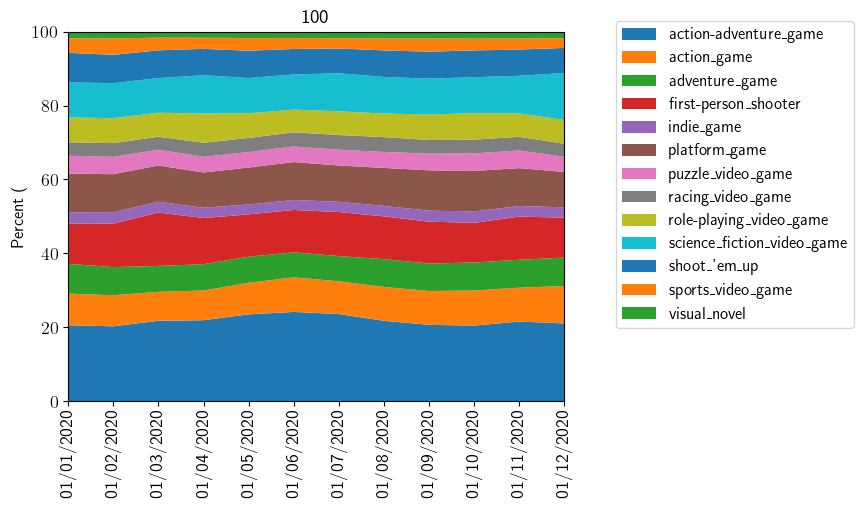

In [25]:
x = dates

fig = plt.figure()
ax = fig.add_subplot(111)

ax.stackplot(x, y.transpose()*100)
ax.set_title('100 % stacked area chart')
ax.set_ylabel('Percent (%)')
ax.legend(count.index,bbox_to_anchor=(1.6, 1.05))
ax.margins(0, 0) # Set margins to avoid "whitespace"
plt.tick_params(axis='x', labelrotation=90)
plt.xticks(dates, date)
plt.show()

# The next steps
These are obviously only preliminary analysis, what we would like to do next is to also extract 2019 values in order to compute a baseline. That way we would be able to compare the trends pre- and post-pandemic. Then, we also want to analyze other types of entertainment like books, films, music, […] using a similar method. A key aspect is also the language; here we only analyzed english, but we will also take a look other languages. This will allow us to compare trends with the available mobility reports.